In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-white')
plt.rcParams["figure.figsize"] = [20, 8]

## Building Energy Consumption


Each building, as an independent system, has its own characteristics and main features, due to that each building was analyzed individually. In a way to simplify these analyses, it is mandatory to identify the patterns that dynamically affect building’s energy consumption. These patterns may rely on key factors that at first sight are critical to energy use, such as occupancy, weather conditions and structural characteristics.

The **stochastic behaviour of the occupants** through their presence and activities in the building, influences energy consumption, not only passively by their metabolic heat produced, but also actively by their energy use (e.g. use of hot water, electrical appliances, lighting, and building openings) which results in an increase of internal heat gains and energy consumption, respectively.


Additionally, **weather conditions parameters, such as outdoor temperature, relative humidity, and solar radiation** are also important factors that may impact building’s indoor thermal comfort and subsequently its inhabitants, mostly due to their annual variation. Thermal comfort can be reached through the proper use of the HVAC system, which is one of the major contributors in terms of energy use.


Furthermore, **buildings’ structure characteristics** is another factor that may affect the indoor environment and consequently, energy consumption. Diverse type of structures and construction materials impact negatively or positively buildings’ overall thermal properties. In a well-conceived building, its structure is used as an energy storage medium that supports building thermal management, by adapting to the various weather conditions scenarios.

To distinguish the different patterns caused by the earlier mention factors, each **building energy consumption was evaluated in monthly, weekly and daily temporal granularities, with the data acquired from the previous year of the forecast, 2017.**

In [2]:
dt_01 = pd.read_csv('Preprocessed_Data/_01_dt_01.csv', index_col=[0], parse_dates=[0], header=0)['2017']
dt_01.head()

,civil,south_tower,wt_temp,wt_tmpap,wt_hr,wt_max_windgust,wt_mean_windspd,wt_mean_pres,wt_mean_solarrad,wt_rain_day,t_hour,t_month,t_dayofweek,t_year,miss_civil,miss_south_tower,miss_wt
timestamp,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,74.897706,100.810001,8.5,5.6,75.0,3.8,2.3,1029.0,1.4,0.0,0,1,6,2017,0,0,0
2017-01-01 01:00:00,75.173556,99.054135,7.9,4.7,76.3,4.3,2.7,1028.2,1.5,0.0,1,1,6,2017,0,0,0
2017-01-01 02:00:00,74.208175,98.539567,7.3,3.7,80.3,4.8,3.3,1028.0,1.4,0.0,2,1,6,2017,0,0,0
2017-01-01 03:00:00,73.735889,101.435784,6.8,3.0,81.3,5.0,3.5,1028.0,1.5,0.0,3,1,6,2017,0,0,0
2017-01-01 04:00:00,75.102351,98.481664,6.5,2.3,81.2,6.8,4.0,1028.0,0.9,0.0,4,1,6,2017,0,0,0


**Prepare the data frame**

In [28]:
def dt_preparation(groupby=False, stats='mean', hours='day'):
    dt_buildings = dt_01[['civil', 'south_tower', 't_month', 't_hour', 't_dayofweek']]
    
    if groupby==True:
        dt_buildings = day_or_night(dt_buildings, hours)
        dt_buildings = assign_names(dt_buildings)
        dt_buildings = groupby_and_index(dt_buildings, stats=stats)
        
        
    dt_buildings = assign_names(dt_buildings)
    dt_buildings = pd.melt(dt_buildings, id_vars=['name_months', 'name_weekdays'] , value_vars=['civil', 'south_tower'],
                           var_name='Building' ,value_name='Consumption (kWh)')

    return dt_buildings

def assign_names(dt):
    # Dictionary to create new columns with names instead of integers for days of week and months
    weekday_keys = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    months_keys = {1:'January', 2:'February', 3: 'March', 4:'April',5: 'May', 6:'June',
                   7:'July', 8:'August', 9:'September', 10:'October',11:'November', 12:'December'}
   
    # Apply dictionaries
    dt['name_weekdays'] = dt['t_dayofweek'].apply(lambda x: weekday_keys.get(x))
    dt['name_months'] = dt['t_month'].apply(lambda x: months_keys.get(x))
    
    return dt

def day_or_night(dt, hours):
    '''
    Select Days of Week and Hours 
    '''
    # Weekdays because is when there is more movement in the faculty
    weekdays = [i for i in range(0, 5)]
    # Day hours from 8 am to 9 pm
    day_hours = [i for i in range(8, 21)]
    # Night hours from 9 pm to 7 am
    night_hours = [i for i in range(0, 8)] + [i for i in range(21, 24)]
    
    # Split the data frame based on time
    if hours == 'day':
        return dt[dt.t_hour.isin(day_hours) & dt.t_dayofweek.isin(weekdays)]
    elif hours == 'night':
        return dt[dt.t_hour.isin(night_hours) & dt.t_dayofweek.isin(weekdays)]
    
def groupby_and_index(dt, stats):
    '''
    Groups by month only
    
    Input: DataFrame
           stats = ['mean', 'max', 'min', 'sum']
    Output: DataFrame Grouped
          
    '''
    indexes = ['January','February','March','April','May','June',
        'July','August','September','October','November','December']
    
    if stats == 'mean':
        return dt.groupby('name_months').mean().reindex(indexes).reset_index()
    elif stats == 'max':
        return dt.groupby('name_months').max().reindex(indexes).reset_index()
    elif stats == 'min':
        return dt.groupby('name_months').min().reindex(indexes).reset_index()
    else:
        return dt.groupby('name_months').sum().reindex(indexes).reset_index()
    
def dt_wt_preparation(wt, hours):
    '''
    Prepares the weather data to be analized with the energy consumption
    Input: wt = ['temp', 'hr', 'mean_solarrad']
    Output: DataFrame
    '''
    dt_wt = dt_01[['t_hour', 't_month', 't_dayofweek', 'wt_temp', 'wt_hr', 'wt_mean_solarrad']]
    
    # Select if day or night hours
    dt_wt = day_or_night(dt_wt, hours)
    dt_wt = assign_names(dt_wt)
        
    dt_wt_max = groupby_and_index(dt_wt, stats='max')
    dt_wt_min = groupby_and_index(dt_wt, stats='min')
    
    wt = 'wt_'+ wt
    
    dt = dt_wt_min[['name_months', wt]]
    dt[wt+'_max'] = dt_wt_max[wt]
    dt.columns = ['months', wt+'_min', wt+'_max']
    
    dt = pd.melt(dt, id_vars=['months'], value_vars=[wt+'_max', wt+'_min'], var_name= wt+'_var', value_name=wt)
    
    return dt

# Function to Box Plot
def boxplot(dt, temp, building, hue_name):
    name = building.split('_')

    if len(name) > 1:
        name = name[0]+' '+name[1]   
    else:
        name = name[0]
    
    plt.figure(figsize=(20, 10))
        
    if temp == 'name_months':   

        plot = sns.boxplot(x=temp, y=building, data=dt, hue=hue_name)
        plot.set_xlabel("Months",fontsize=15)
        plot.set_ylabel("Consumption (kWh)",fontsize=15)
        
    elif temp == 'name_weekdays':

        plot = sns.boxplot(x=temp, y=building, data=dt, hue=hue_name, order=["Monday", "Tuesday", "Wednesday", 
                                                                             'Thursday', 'Friday', 'Saturday', 'Sunday'])
        plot.set_xlabel("Weekday",fontsize=15)
        plot.set_ylabel("Consumption (kWh)",fontsize=15)

    plot.yaxis.set_label_coords(-0.04, 0.5)
    plot.xaxis.set_label_coords(0.5, -0.06)
    plot.tick_params(labelsize=15)
    plot.legend(loc=0, prop={'size': 15})

def bar_line_plot(dt_energy, dt_wt, wt='wt_temp', day=True):    
    if day == True:
        title = '(from 8 am till 8 pm)'
    else:
        title = '(from 9 pm till 7 am)'
    
    fig, ax1 = plt.subplots(figsize=(20, 10))
    # bar plot creation
    ax1 = sns.barplot(x='name_months', y='Consumption (kWh)', data = dt_energy, hue='Building', palette=['seagreen', 'darkorange'])
    # specify we want to share the same x-axis
    ax2 = ax1.twinx()
    # line plot creation
    ax2 = sns.lineplot(x='months', y=wt, data = dt_wt, hue=wt+'_var',sort=False,palette=['red', 'blue'])
    ax1.set_title('Average Energy Consumption by Month '+title, fontsize=24)
    
    ax1.set_ylim(0, dt_energy.iloc[:,-1].max()+50)
    ax1.tick_params(axis='y', labelsize=16)
    ax1.tick_params(axis='x', labelsize=16)
    ax2.tick_params(axis='y', labelsize=16)
    
    ax1.set_xlabel('Month', fontsize=16)
    ax1.set_ylabel('Consumption (kWh)', fontsize=16)
    if wt == 'wt_temp':
        label = 'Temperature (ºC)'
    elif wt == 'wt_hr':
        label = 'Relative Humidity (%)'
    elif wt == 'wt_mean_solarrad':
        label = 'Solar Radiation (kWh/m^2)'
    
    ax2.set_ylabel(label, fontsize=16)

    ax1.legend(loc=2, prop={'size':15})
    ax2.legend(loc=0, prop={'size': 15})
    plt.show()

---

### Monthly Analysis

For this analysis, the yearly energy consumption of the weekdays was divided in daytime (from 8 am till 8 pm) and nighttime (from 9 pm till 7 am). In addition, it is also presented a boxplot for each building, without any filter applied.

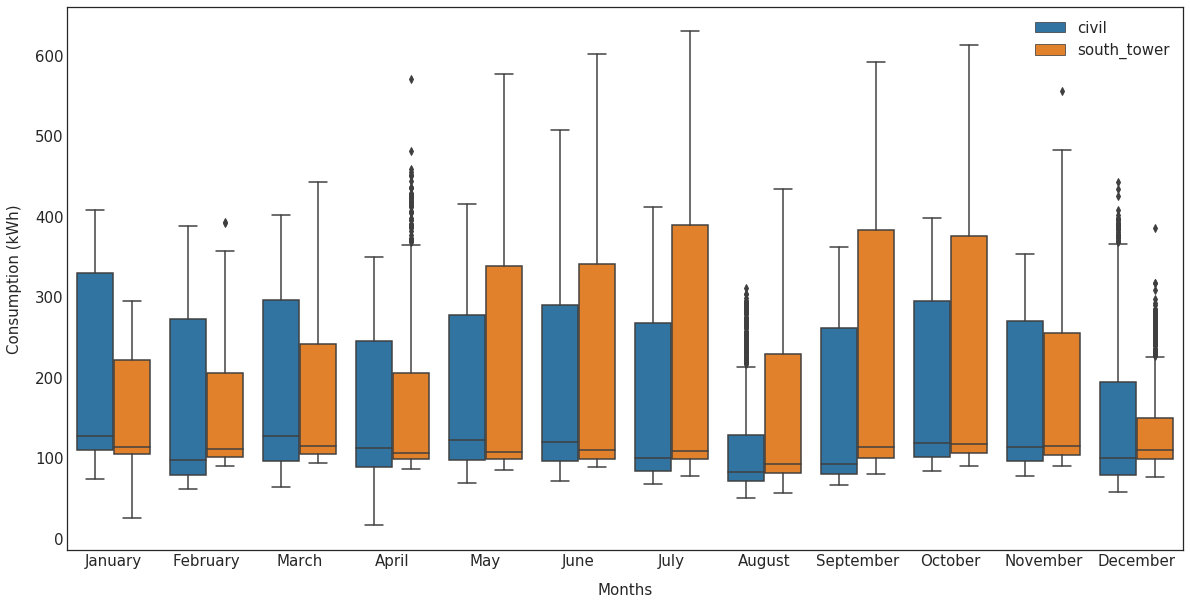

In [31]:
boxplot(dt_preparation(groupby=False), 'name_months', 'Consumption (kWh)', 'Building')

**DAYTIME**

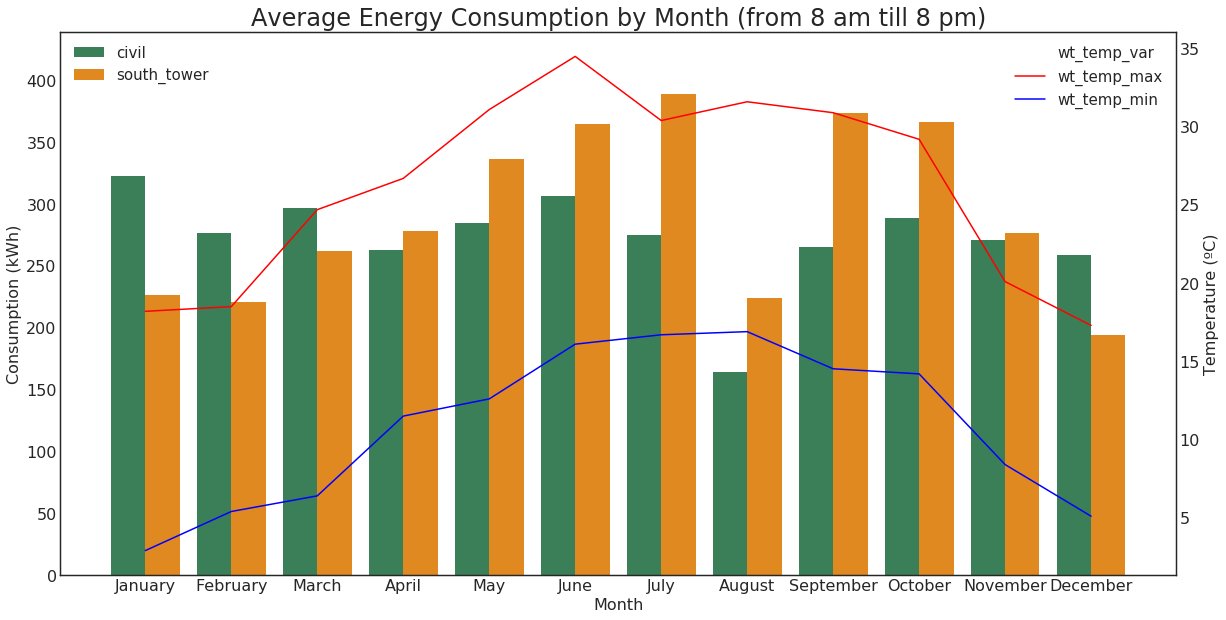

In [19]:
bar_line_plot(dt_preparation(groupby=True, stats='mean', hours='day'), dt_wt_preparation('temp', hours='day'), wt='wt_temp', day=True)

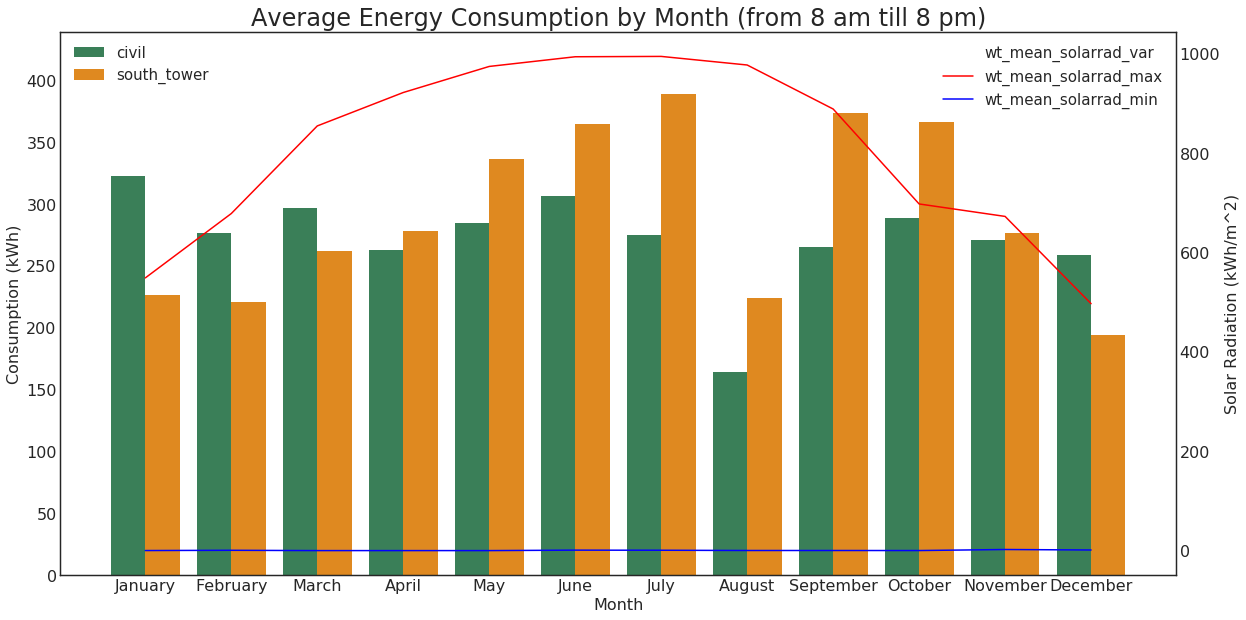

In [30]:
bar_line_plot(dt_preparation(groupby=True, stats='mean', hours='day'), dt_wt_preparation('mean_solarrad', hours='day'), wt='wt_mean_solarrad', day=True)

In general, during the daytime, it is possible to see a higher mean consumption tendency, during the cooling season when compared with heating season. This tendency is highly related to HVAC system energy use to maintain the indoor thermal comfort, in the presence of more adverse conditions, which occurs during summer. Although there is an exception of this tendency, in August, that shows the lowest mean energy consumption when compared with the rest of the months during the year, caused by the two weeks summer break of all campus facilities, which is clearly in boxplot.

Moreover, it is noticeable that South tower is more exposed to the outside conditions than Civil building, achieving higher mean consumptions in the cooling season, this is mostly due to the thermal properties of the glazed facades that surrounds South tower, being more vulnerable to solar energy.

In South Tower it is also perceptible that the consumption fluctuation follows the maximum and minimum temperature variations along the year. This consumption curve is characteristic of buildings using natural gas and electricity for cooling and heating seasons, respectively. In contrast, Civil building presents a more stable consumption curve which is substantiated by the main use of electricity.

**NIGHTTIME**

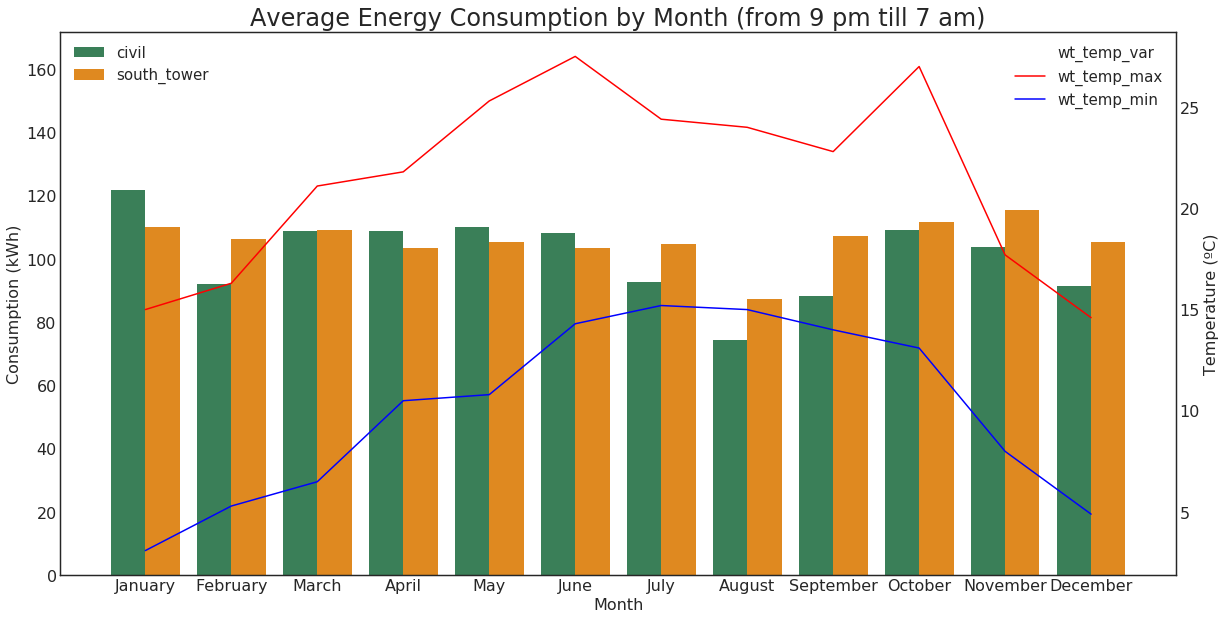

In [16]:
bar_line_plot(dt_preparation(groupby=True, stats='mean', hours='night'), dt_wt_preparation('temp', hours='night'), day=False)

During nighttime, one main behaviour of Civil building' consumption is noticeable. The existence of a study area open 24 hours a day, creates a pattern with higher mean consumption in the months corresponding to the two semesters and evaluation periods.

---

### Weekly Analysis

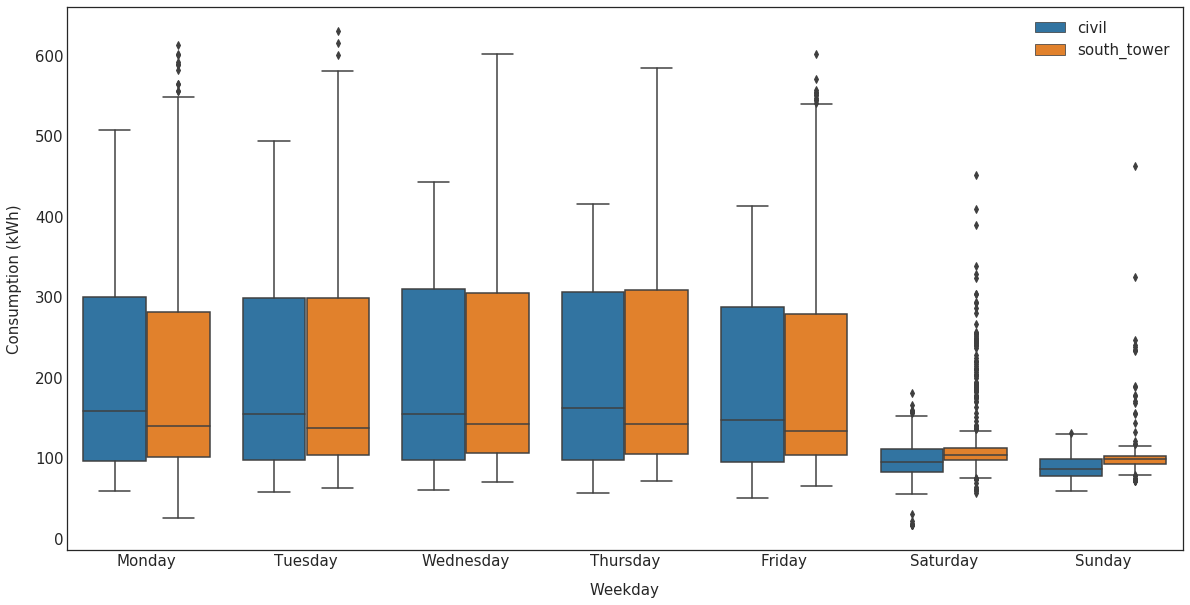

In [7]:
boxplot(dt_preparation(groupby=False), 'name_weekdays', 'Consumption (kWh)', 'Building')

In each building there is a 7 days cycle pattern that repeats almost through the whole year, as it is represented by the weekly boxplots.

As expected, most of the buildings’ energy use occurs during weekdays since it is when the majority of buildings’ activities take place. It is also noticeable a slight decrease in energy expenditure in the last weekday, Friday, probably due to the arriving of week-end and people’s tendency to leave earlier. During the weekend, there is an abrupt fall in energy con-sumption, although Saturday energy use is slightly higher than Sunday, due to weekend opening hours.

Nevertheless, this pattern can be altered by local or national holidays that consequently may reduce buildings’ occupancy rate resulting in less energy expenditure.

---

### Daily Analysis